# Reports
1. Inputs: cleaned data whith feature engineering
2. Outputs: prepared data to ml
3. 

# 1.0 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from xgboost import XGBRFClassifier

from boruta import BorutaPy

import time

tempo_agora = time.time() # Contabilizando o tempo de processamento do projeto

D:\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1.1 Data Imports

In [2]:
df = pickle.load(open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//data//interim//df_to_data_preparation.pkl', 'rb'))

# 2.0 Data Preparation

### 2.1 Transformations

###### 2.1.1 Log de Age

In [3]:
df['Log_Age'] = df['Age'].apply(lambda x: np.log(x) if x>0 else 0);

### 2.2 Preprocessing

In [4]:
backup = df.copy()

In [5]:
df = backup.copy()

# Encodings
temp = pd.get_dummies(df['Geography_enc'], prefix='Geography', drop_first=True)
df = pd.concat([df, temp], axis=1)

# Removing features
features_remover = 'CustomerId Surname Geography Gender Geography_enc RowNumber Age Tenure'.split()
df.drop(features_remover, axis=1, inplace=True)
# print(f'Features que seguirão para a modelagem: {df.drop("Exited", axis=1).columns.to_list()}')

# Split features and target
X = df.drop('Exited', axis=1)
X = np.array(X)
y = df['Exited']
y = np.array(y).reshape(1, len(y))[0]

# Hiding test
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.3, random_state=101)

# Standard and scaler
scaler = StandardScaler()
scaler = scaler.fit(X_)

X_scaler = scaler.transform(X_)
X_train_scaler = scaler.transform(X_train)
X_valid_scaler = scaler.transform(X_valid)
X_test_scaler = scaler.transform(X_test)

# Solving unbalance problem
# smote
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_, y_)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# near
near = NearMiss()
X_near, y_near = near.fit_resample(X_, y_)
X_train_near, y_train_near = near.fit_resample(X_train, y_train)

# 3.0 Feature Selection

## 3.1 Importances

### 3.1.1 Random Forest

In [6]:
print('Validation')
# model definition
rf_model = RandomForestClassifier()

# fiting model
rf_model = rf_model.fit(X_train_smote, y_train_smote)

# validation predicting
predicts = rf_model.predict(X_valid)

print(classification_report(y_valid, predicts))
print(roc_auc_score(y_valid, predicts))
print()
print(confusion_matrix(y_valid, predicts))
print('\nTest')

# test predicting
predicts = rf_model.predict(X_test)

print(classification_report(y_test, predicts))
print(roc_auc_score(y_test, predicts))
print()
print(confusion_matrix(y_test, predicts))

Validation
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1923
           1       0.72      0.49      0.59       477

    accuracy                           0.86      2400
   macro avg       0.80      0.72      0.75      2400
weighted avg       0.85      0.86      0.85      2400

0.7234584980883512

[[1831   92]
 [ 241  236]]

Test
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1577
           1       0.72      0.56      0.63       423

    accuracy                           0.86      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000

0.7492425843725781

[[1487   90]
 [ 188  235]]


In [7]:
rf_importances = pd.DataFrame(rf_model.feature_importances_)
rf_importances.columns = ['rf_importances']

### 3.1.2 XGBoost

In [8]:
print('Validation')
# model definition
xgb_model = XGBRFClassifier(use_label_encoder=False, eval_metric='logloss')

# fiting model
xgb_model = xgb_model.fit(X_train_smote, y_train_smote)

# validation predicting
predicts = xgb_model.predict(X_valid)

print(classification_report(y_valid, predicts))
print(roc_auc_score(y_valid, predicts))
print()
print(confusion_matrix(y_valid, predicts))
print('\nTest')

# test predicting
predicts = xgb_model.predict(X_test)

print(classification_report(y_test, predicts))
print(roc_auc_score(y_test, predicts))
print()
print(confusion_matrix(y_test, predicts))

Validation
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1923
           1       0.65      0.51      0.57       477

    accuracy                           0.85      2400
   macro avg       0.77      0.72      0.74      2400
weighted avg       0.84      0.85      0.84      2400

0.7209156290779932

[[1793  130]
 [ 234  243]]

Test
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1577
           1       0.67      0.56      0.61       423

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.84      0.85      0.84      2000

0.7428152325614514

[[1463  114]
 [ 187  236]]


In [9]:
xgb_importances = pd.DataFrame(xgb_model.feature_importances_)
xgb_importances.columns = ['xgb_importances']

## 3.2 RFE

In [10]:
rfe_model = RFE(xgb_model, n_features_to_select=1)

rfe_fit = rfe_model.fit(X_train_smote, y_train_smote)

selector = rfe_fit.ranking_

selector = pd.DataFrame(selector)

selector.columns = ['rfe']

## 3.3 Boruta

In [11]:
boruta_model = BorutaPy(xgb_model)

boruta_fit = boruta_model.fit(X_train_smote, y_train_smote)

bor_model = boruta_fit.ranking_

bor_model = pd.DataFrame(bor_model)
bor_model.columns = ['boruta']

## 3.4 Comparision

In [12]:
feature_selection = pd.concat([rf_importances, xgb_importances, selector, bor_model], axis=1)
feature_selection.index = df.drop("Exited", axis=1).columns

feature_selection

,rf_importances,xgb_importances,rfe,boruta
CreditScore,0.066686,0.003015,11,3
Balance,0.080797,0.016968,6,1
NumOfProducts,0.156559,0.166271,2,1
HasCrCard,0.035518,0.007151,8,1
IsActiveMember,0.149648,0.311945,1,1
EstimatedSalary,0.076667,0.004437,10,2
Gender_enc,0.091405,0.146179,4,1
tenure_exite_mean,0.052658,0.006030,9,1
Log_Age,0.194130,0.248296,3,1
Geography_1,0.061293,0.077917,5,1


O Boruta e o RFE discortam sobre a feature HasCrCard.

<AxesSubplot:>

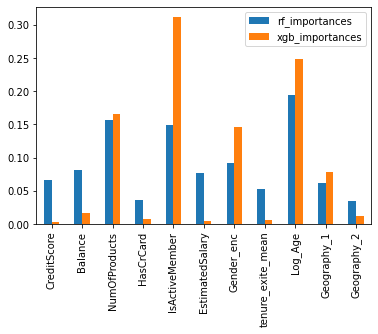

In [13]:
feature_selection.drop(['rfe', 'boruta'], axis=1).plot(kind='bar')

Baseando-se nos estudos dos métodos Importances, RFE e Boruta, o método escolhido para a seleção final foi o BORUTA.

## 3.5 Removing Features

In [15]:
X_valid = np.delete(X_valid, [0, 5], 1)
X_test = np.delete(X_test, [0, 5], 1)
X_smote = np.delete(X_smote, [0, 5], 1)
X_train_smote = np.delete(X_train_smote, [0, 5], 1)
X_near = np.delete(X_near, [0, 5], 1)
X_train_near = np.delete(X_train_near, [0, 5], 1)

# 4.0 Exporting Data

###### 4.1 Arrays

In [16]:
X_to_modeling = [X_valid, X_test, X_smote, X_train_smote, X_near, X_train_near]
y_to_modeling = [y_valid, y_test, y_smote, y_train_smote, y_near, y_train_near]

pickle.dump(X_to_modeling, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//data//processed//X_to_modeling.pkl', 'wb'))
pickle.dump(y_to_modeling, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//data//processed//y_to_modeling.pkl', 'wb'))

###### 4.2 Features_remover

In [17]:
pickle.dump(features_remover, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//deploy//transformers//features_remover.pkl', 'wb'))
pickle.dump(features_remover, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//src//features//features_remover.pkl', 'wb'))

###### 4.3 Scaler

In [18]:
pickle.dump(scaler, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//deploy//transformers//scaler.pkl', 'wb'))
pickle.dump(scaler, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//src//features//scaler.pkl', 'wb'))

# Time

In [19]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-tempo_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 4 minutos
